In [1]:
import pandas as pd
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

### Reading data

In [2]:
data = pd.read_csv("AA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-09-14,23.020741,23.092831,22.395960,22.540140,22.154621,13011200
1,2015-09-15,22.564171,23.333130,22.516109,23.140890,22.745098,7468900
2,2015-09-16,23.309099,23.741640,23.309099,23.693581,23.288336,8279200
3,2015-09-17,23.573429,24.414480,23.429251,23.909849,23.500904,10203100
4,2015-09-18,23.669550,24.102091,23.453279,23.957911,23.548143,12108600


In [3]:
price = data["Close"]
print(price.shape)

(1008,)


In [4]:
y = pd.DataFrame(np.where(price >= price.shift(1), 1, 0))
y.head()

,0
0,0
1,1
2,1
3,1
4,1


In [5]:
y.shape

(1008, 1)

### Empirical mode decompostion

In [6]:
t = np.linspace(0,1,1008)

In [7]:
emd = EMD()

In [8]:
IMFs = emd.emd(data["Close"].to_numpy(), t)

In [9]:
X = pd.DataFrame(IMFs).transpose()
X.head()

,0,1,2,3,4,5
0,-0.102212,-0.368197,0.452060,-0.918902,2.667904,20.809487
1,0.059660,-0.191364,0.773387,-0.982092,2.670744,20.810555
2,0.099556,0.109254,1.011311,-1.008912,2.670497,20.811875
3,-0.081031,0.388174,1.117298,-0.995160,2.667120,20.813447
4,-0.106784,0.482671,1.044481,-0.938434,2.660705,20.815272


In [10]:
X.shape

(1008, 6)

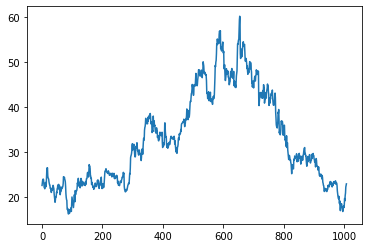

In [11]:
plt.plot(price)

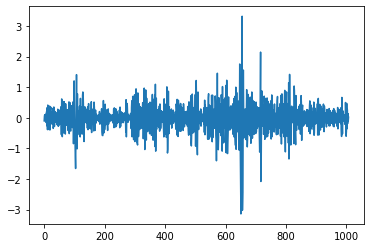

In [12]:
plt.plot(X[0])

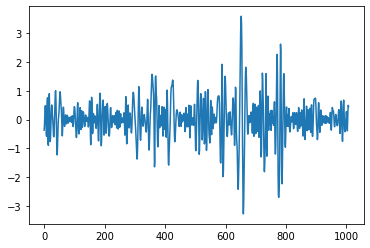

In [13]:
plt.plot(X[1])

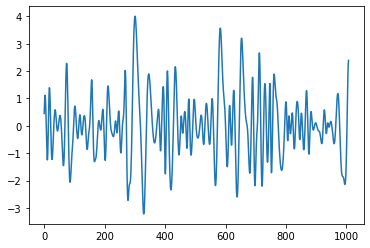

In [14]:
plt.plot(X[2])

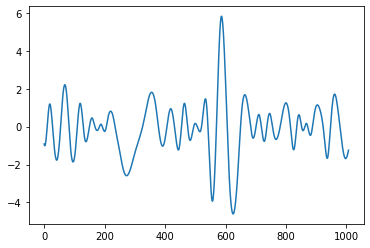

In [15]:
plt.plot(X[3])

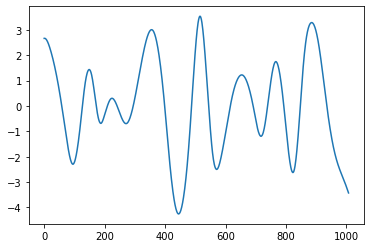

In [16]:
plt.plot(X[4])

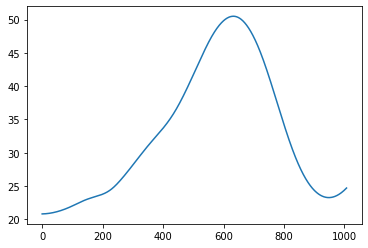

In [17]:
plt.plot(X[5])

### Data preprocessing

In [18]:
y = y[1:]
X = X[:-1]
print(X.shape, y.shape)

(1007, 6) (1007, 1)


In [19]:
scaler = MinMaxScaler()
scaler.fit(X)
scaler.transform(X)

array([[4.70657423e-01, 4.23692484e-01, 5.08081034e-01, 3.53434432e-01,
        8.88025295e-01, 0.00000000e+00],
       [4.95720937e-01, 4.49452860e-01, 5.52577069e-01, 3.47378815e-01,
        8.88389384e-01, 3.59667971e-05],
       [5.01898307e-01, 4.93245731e-01, 5.85523884e-01, 3.44808574e-01,
        8.88357680e-01, 8.04187731e-05],
       ...,
       [4.56877958e-01, 4.62359174e-01, 6.32476575e-01, 3.01474626e-01,
        1.19727411e-01, 1.26304751e-01],
       [5.07597748e-01, 5.22738353e-01, 7.06083869e-01, 3.07822923e-01,
        1.15234536e-01, 1.27827141e-01],
       [4.68628022e-01, 5.49396769e-01, 7.56665360e-01, 3.14805884e-01,
        1.10704039e-01, 1.29372546e-01]])

In [20]:
split_percentage = 0.5
split = int(split_percentage * len(X))
# Train data
X_train = X[:split]
y_train = y[:split]
# Test data 
X_test = X[split:]
y_test = y[split:]

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(503, 6) (503, 1)
(504, 6) (504, 1)


### Build the model

In [22]:
clf = MLPClassifier(max_iter = 20000, activation = 'relu', random_state=0)  
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print('accuracy: % .2f' % accuracy_score(y_test, y_pred_test))

/home/alex/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.73


### Backtesting

In [23]:
data = data[:-1][split:]
data["y"] = y_test
data["y_hat"] = y_pred_test
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,y,y_hat
503,2017-09-12,44.590000,45.200001,44.330002,45.000000,45.000000,4826300,NaN,0
504,2017-09-13,44.610001,45.070000,44.360001,44.910000,44.910000,3372200,0.0,0
505,2017-09-14,44.480000,45.000000,43.750000,44.799999,44.799999,4450600,0.0,1
506,2017-09-15,44.759998,45.090000,44.220001,44.650002,44.650002,5441600,0.0,1
507,2017-09-18,44.799999,45.090000,44.660000,44.910000,44.910000,3224800,1.0,1


In [24]:
data["return"] = np.where(data["y"] == data["y_hat"],\
                           abs(data["Close"].shift(-1) - data["Close"]),\
                           (-abs(data["Close"].shift(-1) - data["Close"])))

In [25]:
data["portfolio_value"] = np.cumsum(data["return"]) + 1000

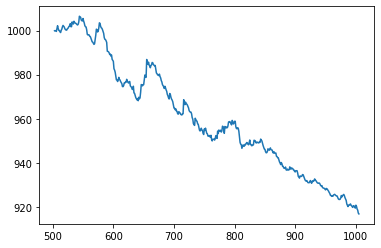

In [26]:
plt.plot(data["portfolio_value"])

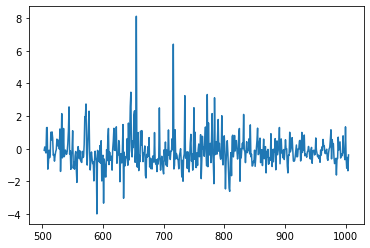

In [27]:
plt.plot(data["return"])

In [28]:
print("mean return: ", np.mean(data["return"]))

mean return:  -0.16548707554671957


In [29]:
print("max drawdown: ", np.min(data["return"]))

max drawdown:  -3.990002000000004


In [30]:
(np.mean(data["return"])/ 1000) *100

-0.016548707554671957